# BERT Plus a Classifier

This notebook puts together a BERT model to encode then get word embeddings at a token level for the ChemE dataset (BETO). It then collates those embeddings, and sends them to a classifier that is just a default model from scikit learn, which is to be decided as to which model is best. This classifier will then classify the individual tokens based on the input vectors. It's nice to have this option, as we can remove all PAD tokens from classification I guess? 

In [1]:
import torch
import random
import os
import nltk
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import tokenize
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split

In [2]:
def extract_xy(df):
    """
    This method extracts and correctly aranges the NER training x-values (tokens)
    and y-values (BESIO labels) from a pandas dataframe containing labeled NER
    data

    Parameters:
        df (pandas DataFrame, required): Dataframe loaded via pd.read_excel() on
            a labeled NER dataset

        endings_dict (dictionary, required): Dictionary containing the indicies
            where each sentence in each line of tokens ends.

    Returns:
        two lists of identical shape. One contains all the words that were tokenized for labeling
        and the other contains all the labels of those tokenized words.
    """
    labeled = []
    columns = df.columns
    new_df = pd.DataFrame()
    all_tokens = []
    besio = []
    mol = []
    IorO = []
        
    for idx, column in enumerate(columns):
        # find every column that starts with 'name'
        if column.startswith('name'):

            # check if the entry in 'name' cell is a str
            if isinstance(df[column][0], str):
                tokens = df[columns[idx + 1]].values
                #find the index where the tokens become NaNs, and chop the token length down to that size. 
                l = 0
                for entries in tokens: 
                    if type(entries) == str:
                        l += 1
                all_tokens.append(tokens[:l])
                df[columns[idx+2]].replace(np.nan, 'O', inplace = True)
                besio.append(df[columns[idx+2]][:l].values)
                df[columns[idx+3]].replace(np.nan, '', inplace = True)
                mol.append(df[columns[idx+3]][:l].values)
                df[columns[idx+4]].replace(np.nan, '', inplace = True)
                IorO.append(df[columns[idx+4]][:l].values)

    i = 0
    label_values = []
    while i < len(besio):
        label_values.append([])
        for j in range(len(besio[i])):
            #Strip unintentional whitespace from all entries:
            besio[i][j] = besio[i][j].replace(" ", "")
            mol[i][j] = mol[i][j].replace(" ", "")
            IorO[i][j] = IorO[i][j].replace(" ", "")
            
            if besio[i][j].upper() == 'O':
                label_values[i].append(besio[i][j].upper())
            if mol[i][j].upper() == 'PRO':
                label_values[i].append(besio[i][j].upper()+'-'+mol[i][j].upper())
            if IorO[i][j].upper() == 'I' or IorO[i][j].upper() == 'O':
                #The below does not handle cases where BESIO or MOL has errors though...
                if mol[i][j].upper() != 'PRO':
                    label_values[i].append(besio[i][j].upper()+'-'+mol[i][j].upper()+'-'+IorO[i][j].upper())
                else: 
                    print("Weird. This Property is organic or inorganic? LOL")
            #PRIME OPPORTUNITY FOR ERROR HANDLING - IF ANYTHING NOT IN THE ABOVE CATS, SOMETHING IS WRONG
            
        i += 1   
    return all_tokens, label_values

In [3]:
def tokenized_to_string(token_list):
    """This function is a helper function that takes the data from the labelled sheets, and turns them 
    from a list format back into a sentence format. Sort of an 'unsplit' method."""
    token_stringlist = []
    for paper_tokens in token_list:
        paper_string = ""
        for i in paper_tokens:
            #This is basically an 'unsplit' method lol
            paper_string += (str(i) + " ")
        token_stringlist.append(paper_string)
    return token_stringlist

In [4]:
def labeled_sheets_to_listed_tokens(directory_url):
    """This function opens a directory of labeled excel sheets from NER labeled excel sheets and returns the tokens as a list 
    of strings fully combined on a document level. It returns a list of strings, with each string being a full document."""
    files = os.listdir(directory_url)
    token_list = []
    label_list = []
    sent_labels = []
    for file in files:
        df = pd.read_excel(directory_url+file)
        token, label = extract_xy(df)
        token_list += (tokenized_to_string(token))
        label_list += (label)
    #Now we tokenize each paper by sentences using NLTK:
    #we will also restructure labels to be ordered by sentences. 
    for i in range(len(token_list)):
        sentences = tokenize.sent_tokenize(token_list[i])
        token_list[i] = sentences
        short_term_labels = []
        for j in range(len(token_list[i])):    
            length = len(token_list[i][j].split())
            short_list = label_list[i][:length]
            short_term_labels.append(short_list)
            del(label_list[i][:length])
        sent_labels.append(short_term_labels)
    return token_list, sent_labels

In [5]:
dir_url = '/Users/Jonathan/Desktop/LabeledChemEData/Labeled_Sheets/'
list_o_tokens, list_o_labels = labeled_sheets_to_listed_tokens(dir_url)

Weird. This Property is organic or inorganic? LOL
Weird. This Property is organic or inorganic? LOL


In [6]:
def drop_empty_sentences(token_list, label_list, label_dict):
    """This function is a form of undersampling an overshadowing case, as it is dropping all examples of sentences where only O labels exist."""
    labels_list = list(label_dict.keys())
    flip = 0
    list_of_deletions = []
    del_counter = 0
    for i in range(len(labels_list)):
        if labels_list[i] == 'O':
            del(labels_list[i])
            flip = 1
        if flip == 1:
            break
    for i in range(len(token_list)):
        for j in range(len(token_list[i])):
            if any(x in label_list[i][j] for x in labels_list):
                pass
            else:
                list_of_deletions.append([i,j])
    print(list_of_deletions)
    while len(list_of_deletions) != 0:
        i,j = list_of_deletions[-1]
        del(label_list[i][j])
        del(token_list[i][j])
        del(list_of_deletions[-1])
        del_counter += 1
    print("Total deleted sentences = " + str(del_counter))
    return token_list, label_list

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [8]:
def max_encoded_length(token_list):
    """This function takes in a full list of all tokens, and determines the max BERT-encoded length
    for any sentence in the corpus, so we can set an appropriate maximum length for our BERT model."""
    max_len = 0
    len_list = []
    for papers in token_list:
        for sentences in papers:
            input_ids = tokenizer.encode(sentences, add_special_characters = True)
            max_len = max(max_len, len(input_ids))
            len_list.append(len(input_ids))
            
    return max_len, len_list

In [9]:
def delete_sentences(token_list, label_list, print_pop = False, max_length = 150):
    """This function takes in the list of tokens and labels, and deletes any sentence that has an 
    encoded tokenized length of greater than max_length. There is an option to print out sentences
    that have been deleted by using print_pop = True. """
    i = 0
    #lets use pop to remove these long sentences
    while i < len(token_list):
        list_of_j = []
        j = 0
        while j < len(token_list[i]):
            input_ids = tokenizer.encode(token_list[i][j], add_special_tokens = True)
            if len(input_ids) > 150:
                print("Found item length: " + str(len(input_ids)))
                list_of_j.append(j)
            j += 1
        k = len(list_of_j)-1
        #Gotta count backwards so we don't disturb the list structure
        while k > -1:
            if print_pop:
                print(token_list[i].pop(list_of_j[k]))
                print(label_list[i].pop(list_of_j[k]))
            else:
                token_list[i].pop(list_of_j[k])
                label_list[i].pop(list_of_j[k])
            k = k - 1
        i += 1 
    return token_list, label_list

In [10]:
#Not sure this is necessary if we don't train the full BERT model, but it's possible.
short_tokens, short_labels = delete_sentences(list_o_tokens, list_o_labels)

Found item length: 181
Found item length: 189
Found item length: 172
Found item length: 270
Found item length: 178
Found item length: 191
Found item length: 171
Found item length: 151
Found item length: 235
Found item length: 161
Found item length: 509
Found item length: 174
Found item length: 207
Found item length: 248
Found item length: 180
Found item length: 155
Found item length: 165
Found item length: 173


There are two label mapping dictionaries that take us from labels to numbers. One captures all of the subtleties of the BIO tagging scheme, and one deletes the BIO tags, and results in just O, MOL, PRO, and PAD/0 tags.

In [11]:
#Maybe we'll get back to this someday
label_mapping = {'O': 13, "B-MOL-O": 1, "I-MOL-O": 2, "E-MOL-O": 3,
                "S-MOL-O": 4, "B-MOL-I": 5, "I-MOL-I": 6, "E-MOL-I": 7,
                "S-MOL-I": 8, "B-PRO": 9, "I-PRO": 10, "E-PRO": 11, "S-PRO": 12,
                'PAD': 0}

In [12]:
#Long term we should absolutely consider going back to the individual labels. Might need
#to have more data than we currently do. Definitely eventually want to separate organic 
#and inorganic chemicals once we get a high-performing model. 
small_label_mapping = {'O': 3, "B-MOL-O": 1, "I-MOL-O": 1, "E-MOL-O": 1,
                "S-MOL-O": 1, "B-MOL-I": 1, "I-MOL-I": 1, "E-MOL-I": 1,
                "S-MOL-I": 1, "B-PRO": 2, "I-PRO": 2, "E-PRO": 2, "S-PRO": 2,
                'PAD': 0}


Part of the reason why we want to expand the input labels at the same level as the tokens is to make sure we have well-alligned labels and tokens for our later work when we pass both the input labels, as well as the encoded token vectors together to the final classifier.

In [13]:
def tokenize_and_align_lables(list_of_tokens, list_of_labels, encoding_dict, max_sent_length = 155):
    """This function takes the token list, BERT-tokenizes it, all while maintaining the match between 
    labels and words. This is important as BERT breaks down full tokens into subwords, so sometimes
    a label will need to span multiple subwords to correctly label the situation. This function
    also builds the padding tokens needed, padding to a length set by max_sent_length."""
    
    input_ids = []
    attention_masks = []
    label_shapes = []
    no_pad_labels = []
    count = 0

    for abstracts, abst_labels in zip(list_of_tokens, list_of_labels):
        for sentences, sent_labels in zip(abstracts, abst_labels):
            encoded_dict = tokenizer.encode_plus(
                                        sentences,
                                        add_special_tokens = True,
                                        max_length = max_sent_length,
                                        pad_to_max_length = True,
                                        return_attention_mask = True,
                                        return_tensors = 'pt'
            )
            #Ok, now we get our labels based on encoded sizes. 
            #Make this a standalone function later instead of nesting
            #Need to start the CLS token to every label. 
            #This CLS token should be a int 0, to keep label
            #length matching consistent with the tokenized sentence
            extend_sent_labels = [0]


            #I Bet the problem with things being read in is the difference in length of 
            #however this chunks sentences versus how the labels were originally split.

            for word, label in zip(sentences, sent_labels):
                tokenized_word = tokenizer.tokenize(word)
                #Find out how many chunks each word gets broken into
                n_subwords = len(tokenized_word)
                #Extend the length of the labels to match new word length
                #Put label in brackets so it knows you want n_subwords entries
                #of label, not label times n_subwords
                extend_sent_labels.extend([label]*n_subwords)

            #In order to know just how much to bias the dataset for each label, we need to know how many of each we have. 
            no_pad_labels.extend(extend_sent_labels)

            #This handles increasing the length for padding and sep tokens
            #Go all the way to 155. Padding and  SEP should both be PAD tokens in label form
            #Because the key map will switch them to a 0. 
            extend_sent_labels.extend(['PAD']*(155-len(extend_sent_labels)))    
    
            #Next step, we need to use the dictionary lookup
            #to replace all the values from this list to become 
            #numbers. for loops to go through the whole list. 
            for i in range(len(extend_sent_labels)):
                if extend_sent_labels[i] in encoding_dict.keys():
                    #Replace the label in extend_set_labels[i] from dict
                    extend_sent_labels[i] = encoding_dict[extend_sent_labels[i]]
            #print(extend_sent_labels)
            #Then, we make the labels list into a tensor.
            #extend_sent_labels = torch.tensor(extend_sent_labels)
            test_list = []
            test_list.append(extend_sent_labels)
            test_list = torch.tensor(test_list)
            #Build our attention mask, labels, and input ids of each item.
            label_shapes.append(test_list)
            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])

    #Make lists we just built into tensors
    input_ids = torch.cat(input_ids, dim = 0)
    attention_masks = torch.cat(attention_masks, dim = 0)
    labels = torch.cat(label_shapes, dim = 0)

    print("Original Sentence: ", list_of_tokens[0][0])
    print("Tokenized IDs: ", input_ids[0])
    print("Extended Labels: ", labels[0])
    
    return input_ids, attention_masks, labels

In [14]:
input_tokens, attention_mask, input_labels = tokenize_and_align_lables(short_tokens, short_labels, small_label_mapping)

1
1
1
Original Sentence:  In the interaction between gas molecules with single-walled carbon nanotube (SWCNT) we show that as a result of collisions the gas scattering contributes with an important background signal and should be considered in SWCNT-based gas sensors.
Tokenized IDs:  tensor([  101,  1999,  1996,  8290,  2090,  3806, 10737,  2007,  2309,  1011,
        17692,  6351, 28991, 28251,  2063,  1006, 25430,  2278,  3372,  1007,
         2057,  2265,  2008,  2004,  1037,  2765,  1997, 28820,  1996,  3806,
        17501, 16605,  2007,  2019,  2590,  4281,  4742,  1998,  2323,  2022,
         2641,  1999, 25430,  2278,  3372,  1011,  2241,  3806, 13907,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0

Now we need to load the tokens, labels, and the generated attention mask into a dataset and dataloader, to reduce load on the computer's memory.

In [15]:
from torch.utils.data import TensorDataset

In [16]:
dataset = TensorDataset(input_tokens, attention_mask, input_labels)

In [17]:
from torch.utils.data import DataLoader, RandomSampler

In [18]:
batch_size = 32
dataloader = DataLoader(dataset,
                        sampler = RandomSampler(dataset),
                        batch_size = batch_size
                        )

In [19]:
from transformers import BertModel, AdamW, BertConfig

In [20]:
model = BertModel.from_pretrained(
        "bert-base-uncased",
        output_attentions = False, #Whether model returns attention weights
        output_hidden_states = False, #Whether model outputs all hidden states                                    
        )

In [21]:
model.cpu()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

Ok, we have the model set up. We can do one of two things: We can build the vectors without fine-tuning the BERT model. That would be simplest honestly. We can do that first, and then once we get a classifier working we can work to fine tune that to a greater extent.

## Opportunity for Enhancement:
Here we should actually fine-tune our BERT model,training it on our specific corpus. It's likely that this will improve our classifier performance, by giving each word a better contextualized embedding. Right now we're just using embeddings and understandings from wikipedia-style written language.

In [22]:
#We do this without the dataloader, only inputting the Input IDs.
#This is NOT FAST. Start 4:05ish. It takes at least 10 minutes to run through.
with torch.no_grad():
    last_hidden_states = model(input_tokens)

Ok, each of these elements in last_hidden_states have a word, and a vector of size 1, 768. 

I'm not sure what the different outputs mean yet. Let me read Jay Alammar's blog thing:
Here's the structure. We want back out element 0 in the tuple of the model's output. These represent our word embeddings. Those elements have a shape of 1268 (ie, number of sentences input), by 155 (length of the sentences), by 768 (the length of the vector embedding for each word). 
So, in order to characterize each word, we'll want to include the embedding for each word as an input into the final neural network. 

In [23]:
embedding_vectors = last_hidden_states[0]

Ok, now that we have the embedding vectors for each specific word, it's time to put them into the new classifier neural network. 

****

# BERT Output Cleaning
Now, we need to take the raw vector output from the BERT model, and rearrange and clean it, so it can be neatly fed into our various classifiers. We will no longer need sentence ordering, as that should be captured within the BERT embeddings, so we can re-sort such that every embedding is in a single linear array.

We'll also need to remove any extraneous outputs, including PAD tokens.


Ok, to do that, our first step is to make sure that we have clean alignment and the same shape between everything. 
I'm actually not sure how to handle the full vector, considering that the hidden states is going to have a value of 768 for each word, and the labels are 1 for each word. I'm sure that's taken in somewhere. 

In [24]:
numpy_embeddings = embedding_vectors.numpy()

In [25]:
#Ok, could improve this by removing the PAD tokens when we get here. 
#Probably the best thing we can do is drop the first one, and then drop the 
#Tokens that are shown as the attention mask, and then also delete the token 
#Where the attention mask of i plus attention mask i+1 == 1, as that's the SEP Token
reshaped_embeddings = []
for i in range(len(numpy_embeddings)):
    for j in range(len(numpy_embeddings[i])):
        reshaped_embeddings.append(numpy_embeddings[i][j])

Ok, now we need to reshape the labels, and send them to a numpy array, instead of a torch tensor. 

In [26]:
numpy_labels = input_labels.numpy()

In [27]:
reshaped_labels = []
for i in range(len(numpy_labels)):
    for j in range(len(numpy_labels[i])):
        reshaped_labels.append(numpy_labels[i][j])

Now we must reshape the attention mask, so we have a way of figuring out what is a padding token, and what's not. 

In [28]:
numpy_attention = attention_mask.numpy()

In [29]:
#Next step, need to remove all padding from all the tokens
reshaped_attention_mask = []
for i in range(len(numpy_attention)):
    for j in range(len(numpy_attention[i])):
        reshaped_attention_mask.append(numpy_attention[i][j])

Ok, our next step is to drop every place in all three matrices where the attention mask equals zero. This will functionally remove all of the PAD tokens from all the sentences, making it such that we're not training any of our classifiers on padding tokens. This should enable us to only focus on differentiating Outside tokens from Properties and Chemicals.

In [30]:
list_of_pads = []
for i in range(len(reshaped_labels)):
    #Now we start looking at the atten mask and see where it's 0.
    if reshaped_attention_mask[i] == 0:
        list_of_pads.append(i)      

In [31]:
#First, we need to sort the list of pads by descending, so we can start at the end of the list.
desc_list_pads = sorted(list_of_pads, reverse = True)

In [32]:
padded_percentage_list = [0,0,0,0]
for i in range(len(reshaped_labels)):
    padded_percentage_list[reshaped_labels[i]] += 1

In [33]:
padded_percentage_list

[173810, 2904, 987, 19459]

In [34]:
173810/(173810+2904+987+19459)

0.881568269425847

In [35]:
no_pad_labels = reshaped_labels.copy()
no_pad_tokens = reshaped_embeddings.copy()
current_len = len(no_pad_labels)-1
while -1 < current_len:
    if no_pad_labels[current_len] == 0:
        del(no_pad_labels[current_len])
        del(no_pad_tokens[current_len])
    current_len -= 1      

In [36]:
len(no_pad_tokens)

23350

In [37]:
len(no_pad_labels)

23350

In [38]:
final_percentage_list = [0,0,0,0]
for i in range(len(no_pad_labels)):
    final_percentage_list[no_pad_labels[i]] += 1

In [39]:
final_percentage_list

[0, 2904, 987, 19459]

In [40]:
final_percentage_list[3]/(sum(final_percentage_list))

0.8333618843683084

****

## Classifier Building and Training

Alright, the inputs are fully ready and cleaned, time to start putting them into different classifiers and showing how the different classifiers perform.

In [41]:
#Alright, now that we've removed all the padding components, let's put in a model!
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [42]:
#Split on a 75-25 to start, we can modify later. 
train_tokens, test_tokens, train_labels, test_labels  = train_test_split(no_pad_tokens, no_pad_labels)

In [46]:
lr_clf = LogisticRegression()
lr_clf.fit(train_tokens, train_labels)

C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
lr_clf.score(test_tokens, test_labels)

0.8278520041109969

In [48]:
predictions_for_test = lr_clf.predict(test_tokens)

In [49]:
guess_list = [0,0,0,0]
for i in range(len(predictions_for_test)):
    guess_list[predictions_for_test[i]] += 1

In [50]:
guess_list

[0, 148, 15, 5675]

In [51]:
percentage_list = [0,0,0,0]
for i in range(len(test_labels)):
    percentage_list[test_labels[i]] += 1

In [52]:
percentage_list

[0, 722, 242, 4874]

In [53]:
percentage_list[3]/sum(percentage_list)

0.8348749571771155

In [73]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [217]:
parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(train_tokens, train_labels)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469

best parameters:  {'C': 0.0001}
best scrores:  0.8333714024668799


Ok, now let's try to deal with introducing weights to the model first, using a built in method of CRF: class_weight : dict or 'balanced', optional (default=None)

In [230]:
weighted_LR_CLF = LogisticRegression(class_weight = 'balanced')
weighted_LR_CLF.fit(train_tokens, train_labels)

C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [231]:
weighted_LR_CLF.score(test_tokens, test_labels)

0.7423775265501884

In [232]:
weighted_predictions = weighted_LR_CLF.predict(test_tokens)

In [233]:
weighted_guess_list = [0,0,0,0]
for i in range(len(weighted_predictions)):
    weighted_guess_list[weighted_predictions[i]] += 1

In [234]:
weighted_guess_list

[0, 706, 429, 4703]

In [235]:
percentage_list

[0, 742, 231, 4865]

In [63]:
from sklearn.metrics import confusion_matrix

In [238]:
conf_mat = confusion_matrix(test_labels, weighted_predictions)

In [242]:
conf_mat

array([[ 220,   61,  461],
       [  23,   40,  168],
       [ 463,  328, 4074]], dtype=int64)

In [239]:
import pandas as pd

In [251]:
confusion_mat = pd.DataFrame(conf_mat, columns = ["Actual 1", "Actual 2", "Actual 3"], index = ["Guess 1", "Guess 2", "Guess 3"])

In [252]:
confusion_mat

,Actual 1,Actual 2,Actual 3
Guess 1,220,61,461
Guess 2,23,40,168
Guess 3,463,328,4074


In [254]:
params = {'C': np.linspace(0.0001, 100, 20)}
weight_grid_search = GridSearchCV(LogisticRegression(class_weight = 'balanced'), params)
weight_grid_search.fit(train_tokens, train_labels)

print('best parameters: ', weight_grid_search.best_params_)
print('best scrores: ', weight_grid_search.best_score_)

C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469

best parameters:  {'C': 0.0001}
best scrores:  0.8318296025582458


In [255]:
#Started at 4:22. Done at 5:10. Best param 0.0001, score 0.831829

In [312]:
optimized_weighted_LR_CLF = LogisticRegression(class_weight = 'balanced', C = 10)

In [313]:
optimized_weighted_LR_CLF.fit(train_tokens, train_labels)

C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [314]:
opt_weight_predicts = optimized_weighted_LR_CLF.predict(test_tokens)

In [315]:
opt_weighted_guess_list = [0,0,0,0]
for i in range(len(opt_weight_predicts)):
    opt_weighted_guess_list[opt_weight_predicts[i]] += 1

In [316]:
opt_weighted_guess_list

[0, 711, 438, 4689]

In [317]:
opt_weight_conf_mat = confusion_matrix(opt_weight_predicts, test_labels)
opt_weight_confusion_mat = pd.DataFrame(opt_weight_conf_mat, columns = ["Actual 1", "Actual 2", "Actual 3"], index = ["Guess 1", "Guess 2", "Guess 3"])

In [318]:
opt_weight_confusion_mat

,Actual 1,Actual 2,Actual 3
Guess 1,220,23,468
Guess 2,65,40,333
Guess 3,457,168,4064


In [319]:
optimized_weighted_LR_CLF.score(test_tokens, test_labels)

0.7406646111682083

C of 0.01, with weights:
Actual 1	Actual 2	Actual 3
Guess 1	188	18	364
Guess 2	32	26	171
Guess 3	522	187	4330

Percentage = 77.8%

C of 0.1 with weights:
Actual 1	Actual 2	Actual 3
Guess 1	212	22	438
Guess 2	56	38	289
Guess 3	474	171	4138
percentage: 75.2%

C of 10 with weights:

Actual 1	Actual 2	Actual 3
Guess 1	220	23	468
Guess 2	65	40	333
Guess 3	457	168	4064
precentage 74.06%

In [311]:
#Ok, so it looks like simple logistic regression isn't doing it? I'm assuming we're having continuing problems
#From the continuing imbalance of data.

In [74]:
from sklearn.ensemble import RandomForestClassifier

In [322]:
RFWeightclassifier = RandomForestClassifier(n_estimators=1000, random_state=0, class_weight = 'balanced')

In [323]:
RF_Weight_fit = RFWeightclassifier.fit(train_tokens, train_labels)

In [324]:
RF_Weight_fit.score(test_tokens, test_labels)

0.8336759164097294

In [325]:
RF_Predictions = RF_Weight_fit.predict(test_tokens)

In [326]:
rf_weighted_guess_list = [0,0,0,0]
for i in range(len(RF_Predictions)):
    rf_weighted_guess_list[RF_Predictions[i]] += 1

In [327]:
rf_weighted_guess_list

[0, 0, 2, 5836]

In [329]:
#With these params, it takes about 30 hours
param_grid = { 
    'n_estimators': [200, 500, 1000, 2500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [331]:
CV_rfc = GridSearchCV(estimator=RFWeightclassifier, param_grid=param_grid, cv= 5)
CV_rfc.fit(train_tokens, train_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=1000, n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             ii

In [334]:
print('best parameters: ', CV_rfc.best_params_)
print('best scrores: ', CV_rfc.best_score_)

best parameters:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 2500}
best scrores:  0.7192782092279579


In [333]:
CV_rfc.score(test_tokens, test_labels)

0.7065775950668037

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=1000, n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500, 1000, 2500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [335]:
weight_random_forest = RandomForestClassifier(n_estimators=2500, random_state=0, max_depth = 8, max_features = 'auto',
                                              criterion= 'gini', class_weight = 'balanced')

In [336]:
weight_random_forest.fit(train_tokens, train_labels)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=2500, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [337]:
RF_predictions = weight_random_forest.predict(test_tokens)

In [341]:
weight_random_forest.score(test_tokens, test_labels)

0.7065775950668037

In [338]:
rf_weighted_guess_list = [0,0,0,0]
for i in range(len(RF_predictions)):
    rf_weighted_guess_list[RF_predictions[i]] += 1

In [339]:
rf_weighted_guess_list

[0, 1418, 129, 4291]

In [343]:
opt_weight_rf_conf_mat = confusion_matrix(RF_predictions, test_labels)
opt_weight_rf_confusion_mat = pd.DataFrame(opt_weight_rf_conf_mat, columns = ["Actual 1", "Actual 2", "Actual 3"], index = ["Guess 1", "Guess 2", "Guess 3"])

In [344]:
opt_weight_rf_confusion_mat

,Actual 1,Actual 2,Actual 3
Guess 1,355,53,1010
Guess 2,8,18,103
Guess 3,379,160,3752


In [75]:
from sklearn.svm import SVC

In [345]:
weighted_support_vector_classifier = SVC(class_weight = 'balanced')

In [364]:
#With these params, it takes well over 20 hours
param_grid_SVC = {
    'gamma': [1, 0.1, 0.001, 0.0001, 0.00001],
    'C': [0.1, 1, 10, 100, 1000]
}

best parameters:  {'C': 1, 'gamma': 1}
best scrores:  0.8334285061671997

Unfortunately, this is the case because it guesses everything as being outside :/

In [ ]:
param_grid_SVC = {
    'gamma': [10, 1, 0.1],
    'C': [1, 10]
}

In [367]:
CV_SVC = GridSearchCV(estimator=weighted_support_vector_classifier, param_grid=param_grid_SVC, cv= 5)
CV_SVC.fit(train_tokens, train_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                           coef0=0.0, decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 10], 'gamma': [10, 1, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [370]:
print('best parameters: ', CV_SVC.best_params_)
print('best scrores: ', CV_SVC.best_score_)

best parameters:  {'C': 1, 'gamma': 1}
best scrores:  0.8334285061671997


In [371]:
weighted_SVC = SVC(class_weight = 'balanced', gamma = 10, C = 10)

In [372]:
weighted_SVC.fit(train_tokens, train_labels)

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [373]:
weighted_SVC.score(test_tokens, test_labels)

0.8333333333333334

In [374]:
SVC_predict = weighted_SVC.predict(test_tokens)

In [375]:
SVC_weighted_guess_list = [0,0,0,0]
for i in range(len(SVC_predict)):
    SVC_weighted_guess_list[SVC_predict[i]] += 1
print(SVC_weighted_guess_list)

[0, 0, 0, 5838]


In [376]:
opt_weight_svc_conf_mat = confusion_matrix(SVC_predict, test_labels)
opt_weight_svc_confusion_mat = pd.DataFrame(opt_weight_svc_conf_mat, columns = ["Actual 1", "Actual 2", "Actual 3"], index = ["Guess 1", "Guess 2", "Guess 3"])

In [377]:
opt_weight_svc_confusion_mat

,Actual 1,Actual 2,Actual 3
Guess 1,0,0,0
Guess 2,0,0,0
Guess 3,742,231,4865


# Naive Bayes - Complement
I tried to set up the Naive Bayes Complement method, but it breaks for negative numbers, so I can't use it without normalizing vectors, and I've read that that causes problems. I'm leaving it in case something changes and it becomes worthwhile to re-explore.

In [348]:
from sklearn.naive_bayes import ComplementNB

In [358]:
comp_NB = ComplementNB()

In [362]:
param_grid_comp_NB = {
    'alpha': [0.1, 0.2, 1, 10, 100]
}

In [363]:
CV_comp_NB = GridSearchCV(estimator = comp_NB, param_grid = param_grid_comp_NB)
CV_comp_NB.fit(train_tokens, train_labels)

C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Input X must be non-negative

In [ ]:
print('best parameters: ', CV_comp_NB.best_params_)
print('best scrores: ', CV_comp_NB.best_score_)

In [ ]:
opt_weighted_comp_NB = ComplementNB(alpha = )
opt_weighted_comp_NB.fit(train_tokens, train_labels)

In [ ]:
opt_weighted_comp_NB.score(test_tokens, test_labels)

In [ ]:
comp_NB_predict = opt_weighted_comp_NB.predict(test_tokens)

In [ ]:
comp_NB_weighted_guess_list = [0,0,0,0]
for i in range(len(comp_NB_predict)):
    comp_NB_weighted_guess_list[comp_NB_predict[i]] += 1
print(comp_NB_weighted_guess_list)

In [ ]:
opt_weight_comp_NB_conf_mat = confusion_matrix(comp_NB_predict, test_labels)
opt_weight_comp_NB_confusion_mat = pd.DataFrame(opt_weight_comp_NB_conf_mat, columns = ["Actual 1", "Actual 2", "Actual 3"], index = ["Guess 1", "Guess 2", "Guess 3"])

# AdaBoost Classifier

In [76]:
from sklearn.ensemble import AdaBoostClassifier

In [381]:
adaboost = AdaBoostClassifier()

In [383]:
param_grid_adaboost = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 1, 10]
}

In [384]:
CV_adaboost = GridSearchCV(estimator = adaboost, param_grid = param_grid_adaboost)
CV_adaboost.fit(train_tokens, train_labels)

C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.1, 1, 10],
                         'n_estimators': [50, 100, 150]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [385]:
print('best parameters: ', CV_adaboost.best_params_)
print('best scrores: ', CV_adaboost.best_score_)

best parameters:  {'learning_rate': 0.1, 'n_estimators': 50}
best scrores:  0.8333714024668799


In [387]:
adaboost_predict = CV_adaboost.predict(test_tokens)

In [389]:
adaboost_weighted_guess_list = [0,0,0,0]
for i in range(len(adaboost_predict)):
    adaboost_weighted_guess_list[adaboost_predict[i]] += 1
print(adaboost_weighted_guess_list)

[0, 0, 0, 5838]


In [395]:
final_adaboost = AdaBoostClassifier(n_estimators = 200, learning_rate = 0.01)

In [396]:
final_adaboost.fit(train_tokens, train_labels)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.01,
                   n_estimators=200, random_state=None)

In [397]:
final_adaboost_predict = final_adaboost.predict(test_tokens)

In [398]:
final_adaboost_weighted_guess_list = [0,0,0,0]
for i in range(len(final_adaboost_predict)):
    final_adaboost_weighted_guess_list[final_adaboost_predict[i]] += 1
print(final_adaboost_weighted_guess_list)

[0, 0, 0, 5838]


# Subsampling Outside Tokens

It seems like all of the above methods are suffering significantly because of the class imbalances. Let's build a method that allows for subsampling the outside tokens by a certain percentage. 

I think we basically want a counter, and based on the counter, we drop outside tokens.
We could also add the option of doing it such that you auto-scale the number of outside tokens to produce balanced classes, but that's not necessary off the bat.

In [38]:
#For every ten outside tokens, drop 6 of them.
drop_number = 6

In [39]:
drop_number = 8

In [40]:
subsampled_tokens = []
subsampled_labels = []
drop_counter = 1
total_counter = 0
for i in range(len(no_pad_labels)):
    total_counter += 1
    if no_pad_labels[i] == 3:
        if drop_counter < drop_number:
            drop_counter += 1
        else:
            #Append or extend?
            subsampled_tokens.append(no_pad_tokens[i])
            subsampled_labels.append(no_pad_labels[i])
    else:
        subsampled_tokens.append(no_pad_tokens[i])
        subsampled_labels.append(no_pad_labels[i])
    if total_counter%10 == 0:
        drop_counter = 1

In [57]:
len(subsampled_labels)

7632

In [58]:
len(no_pad_labels)

23350

In [59]:
subsampled_label_content = [0,0,0,0]
for i in range(len(subsampled_labels)):
    subsampled_label_content[subsampled_labels[i]] += 1
print(subsampled_label_content)

[0, 2904, 987, 3741]


In [60]:
label_content = [0,0,0,0]
for i in range(len(no_pad_labels)):
    label_content[no_pad_labels[i]] += 1
print(label_content)

[0, 2904, 987, 19459]


In [81]:
7915/19459

0.40675265943779226

In [41]:
#Now a train/test split on the subsampled labels
sub_train_tokens, sub_test_tokens, sub_train_labels, sub_test_labels  = train_test_split(subsampled_tokens, subsampled_labels)

NameError: name 'train_test_split' is not defined

In [443]:
weighted_LR_CLF = LogisticRegression(class_weight = 'balanced', max_iter = 10000, tol = 0.000001)
weighted_LR_CLF.fit(sub_train_tokens, sub_train_labels)

C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='warn', n_jobs=None,
                   penalty='l2', random_state=None, solver='warn', tol=1e-06,
                   verbose=0, warm_start=False)

In [444]:
weighted_LR_CLF.score(sub_test_tokens, sub_test_labels)

0.5613207547169812

In [449]:
sub_predict_LR = weighted_LR_CLF.predict(sub_test_tokens)

In [450]:
sub_LR_predictions = [0,0,0,0]
for i in range(len(sub_predict_LR)):
    sub_LR_predictions[sub_predict_LR[i]] += 1
print(sub_LR_predictions)

[0, 736, 331, 841]


In [451]:
sub_LR_conf_mat = confusion_matrix(sub_predict_LR, sub_test_labels)
sub_LR_confusion_mat = pd.DataFrame(sub_LR_conf_mat, columns = ["Actual 1", "Actual 2", "Actual 3"], index = ["Guess 1", "Guess 2", "Guess 3"])

In [452]:
sub_LR_confusion_mat

,Actual 1,Actual 2,Actual 3
Guess 1,450,70,216
Guess 2,105,83,143
Guess 3,210,93,538


In [436]:
params = {'C': np.linspace(0.0001, 100, 10)}
sub_LR_Grid = GridSearchCV(LogisticRegression(class_weight = 'balanced'), params)
sub_LR_Grid.fit(sub_train_tokens, sub_train_labels)

print('best parameters: ', sub_LR_Grid.best_params_)
print('best scrores: ', sub_LR_Grid.best_score_)

C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469

best parameters:  {'C': 0.0001}
best scrores:  0.675626835328665


In [431]:
sub_svc = SVC(class_weight = 'balanced', C = 1, gamma = 1)

In [433]:
sub_svc.fit(sub_train_tokens, sub_train_labels)

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [435]:
sub_svc.score(sub_test_tokens, sub_test_labels)

0.6717479674796748

# NN-Based 1-layer Classifier

To follow: HuggingFace's classifier. It has a dropout layer, then a linear layer. Learn dropout, what it means. Then, do the Linear layer with input features of 768, output layers of 4 (ie, number of examples), and bias = True. Probably also do a weight instantiation as we did before. 

In [45]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [46]:
class Net(nn.Module):
    def __init__(self, p = 0.1):
        super(Net, self).__init__()
        self.classifier_dropout = nn.Dropout(p = p)
        self.classifier = nn.Linear(768,4)
    def forward(self, x):
        x = self.classifier_dropout(x)
        x = self.classifier(x)
        return x

In [ ]:
net = Net()

Ok, now that we have our desired NN construction, we need to build an appropriate training loop. We'll also need to define an optimizer, and set some hyperparameters for the optimizer.

In [ ]:
#Set up a loss function instantiation, using cross-entropy loss:
#Note that we can add custom weights later, if desired.
criterion = nn.CrossEntropyLoss()

In [ ]:
#Set up what we'll use as an optimizer, and call it optimizer
optimizer = optim.SGD(net.parameters(), lr = 0.1, momentum = 0.5)

In [ ]:
#Flip our data into torch tensors
token_tensor = torch.tensor(no_pad_tokens, requires_grad = True)
label_tensor = torch.tensor(no_pad_labels, requires_grad = False)

In [130]:
token_tensor.size()

torch.Size([23350, 768])

In [131]:
label_tensor.size()

torch.Size([23350])

In [132]:
loss_tracker = []

In [133]:
#train for 100 epochs, cool. Lol it took like 30 seconds tops. 
for epoch in range(100):
    optimizer.zero_grad()
    outputs = net(token_tensor)
    loss = criterion(outputs, label_tensor)
    loss.backward()
    optimizer.step()
    
    #Ok, we need some way to save the losses as we go. 
    loss_tracker.append(loss.item())

In [134]:
loss_tracker

[1.5745302438735962,
 1.058039665222168,
 1.239974856376648,
 0.9770456552505493,
 0.5890357494354248,
 0.8493056297302246,
 0.7197505831718445,
 0.7166421413421631,
 0.5536882877349854,
 0.6085219979286194,
 0.5494093298912048,
 0.540581464767456,
 0.5344876050949097,
 0.5249416828155518,
 0.52367103099823,
 0.521517813205719,
 0.5201337337493896,
 0.5174328088760376,
 0.5167601704597473,
 0.517175555229187,
 0.5158080458641052,
 0.5150302648544312,
 0.5138731598854065,
 0.513285756111145,
 0.5124340653419495,
 0.5124878883361816,
 0.5103779435157776,
 0.5103683471679688,
 0.5088686347007751,
 0.5096930861473083,
 0.509178638458252,
 0.5086044669151306,
 0.5072929859161377,
 0.5074989795684814,
 0.5054764747619629,
 0.5063095688819885,
 0.5051511526107788,
 0.5055755376815796,
 0.5047298669815063,
 0.5038321614265442,
 0.5030549764633179,
 0.5025308132171631,
 0.5027132630348206,
 0.5018325448036194,
 0.5018911361694336,
 0.5029997229576111,
 0.5017653107643127,
 0.5000877976417542,
 

Text(0.5, 1.0, 'CE Loss vs Training Epoch, Unweighted')

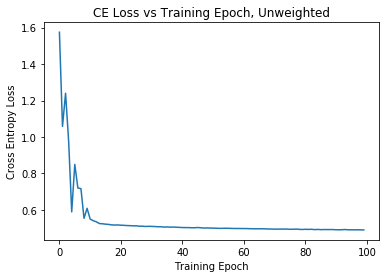

In [138]:
plt.plot(loss_tracker)
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Training Epoch")
plt.title("CE Loss vs Training Epoch, Unweighted")

Ok, we've gone through and gotten the model to work at least once, and it definitely looks reasonable --- continually decreasing loss with increasing time. It looks like lr of 0.1 or 0.01 works about the same, and comes to a loss of about 0.5 pretty quickly. Plot above shows this decently well, for lr = 0.1. 
All that being said, we need a train-test split still, so we can get things that are not loss. Then, we'll want to do a training epoch, into a testing epoch, and see how it performs at each epoch on a test set. 

In [168]:
linear_net = Net()

In [169]:
#Set up what we'll use as an optimizer, and call it optimizer
linear_optimizer = optim.SGD(linear_net.parameters(), lr = 0.1, momentum = 0.5)

In [81]:
#Now we need to make our training and testing tokens
train_NN_tokens, test_NN_tokens, train_NN_labels, test_NN_labels = train_test_split(no_pad_tokens, no_pad_labels)

In [82]:
#Ok, and then flip the training and testing tokens into a torch tensor.
torch_train_tokens = torch.tensor(train_NN_tokens, requires_grad = True)
torch_train_labels = torch.tensor(train_NN_labels)
torch_test_tokens = torch.tensor(test_NN_tokens, requires_grad = True)
torch_test_labels = torch.tensor(test_NN_labels)

In [172]:
train_loss_tracker = []
test_loss_tracker = []
test_predictions = []
test_accuracy_tracker = []
train_accuracy_tracker = []
#train for 100 epochs, cool. Lol it took like 30 seconds tops. 
for epoch in range(100):
    if epoch % 15 == 0:
        print("In epoch: ", epoch)
        flag = True
        
    else:
        flag = False
    
    linear_net.train()
    linear_optimizer.zero_grad()
    train_outputs = linear_net(torch_train_tokens)
    train_loss = criterion(train_outputs, torch_train_labels)
    train_loss.backward()
    linear_optimizer.step()
    #print(epoch)
    #Ok, we need some way to save the losses as we go. 
    train_loss_tracker.append(train_loss.item())
    #Really interesting to note that calc accuracy REALLY SLOWS THIS DOWN
    #Maybe sparsify accuracy to be ever 5 epochs?
    train_accuracy_tracker.append(flat_accuracy(train_outputs, torch_train_labels))
    
    #Once we've done a training step, then move to a testing step:
    linear_net.eval()
    #Make sure we don't have gradients going
    with torch.no_grad():
        test_outputs = linear_net(torch_test_tokens)
    
    #Ok, now calculate test_loss
    test_loss = criterion(test_outputs, torch_test_labels)
    test_loss_tracker.append(test_loss.item())
    
    
    numpy_test_outputs = test_outputs.detach().cpu().numpy()
    #Final step is to find some way to keep track of the model's predictions over time
    test_predictions.append(numpy_test_outputs)
    test_accuracy_tracker.append(flat_accuracy(numpy_test_outputs, torch_test_labels))

In epoch:  0
In epoch:  15
In epoch:  30
In epoch:  45
In epoch:  60
In epoch:  75
In epoch:  90


In [70]:
def plot_loss(test_loss_list, train_loss_list):
    "Takes in lists of the test and training losses, and makes a simple plot."
    plt.plot(test_loss_list, label = 'Test Loss')
    plt.plot(train_loss_list, label = 'Train Loss')
    plt.ylabel("Cross Entropy Loss")
    plt.xlabel("Training Epoch")
    plt.title("CE Loss vs Training Epoch, Unweighted")
    plt.legend()
    plt.show()

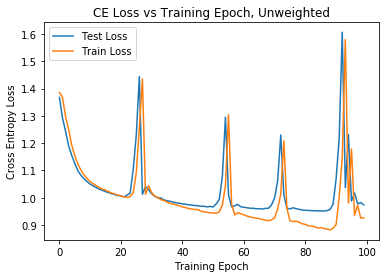

In [79]:
plt.plot(test_loss_tracker, label = 'Test Loss')
plt.plot(train_loss_tracker, label = 'Train Loss')
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Training Epoch")
plt.title("CE Loss vs Training Epoch, Unweighted")
plt.legend()
plt.show()

In [69]:
def plot_accuracy(test_accuracy_list, train_accuracy_list, ylim_min = 0.7, ylim_max = 1.05):
    "Function that takes in lists of testing and training accuracy and makes a simple plot"
    plt.plot(test_accuracy_list, label = 'Test Accuracy')
    plt.plot(train_accuracy_list, label = 'Train Accuracy')
    plt.ylabel("Flat Accuracy")
    plt.xlabel("Training Epoch")
    plt.ylim(ylim_min, ylim_max)
    plt.title("Accuracy vs Training Epoch, Unweighted")
    plt.legend()
    plt.show()

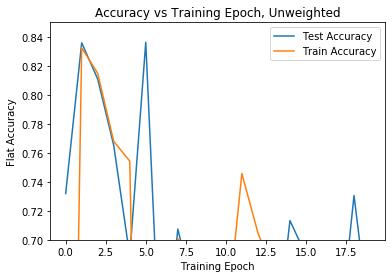

In [80]:
plt.plot(test_accuracy_tracker, label = 'Test Accuracy')
plt.plot(train_accuracy_tracker, label = 'Train Accuracy')
plt.ylabel("Flat Accuracy")
plt.xlabel("Training Epoch")
plt.ylim(0.7, 0.85)
plt.title("Accuracy vs Training Epoch, Unweighted")
plt.legend()
plt.show()

# Next two steps!
1. Make an accuracy function, and call it along the way. Implement both F1 and flat accuracy, just for kicks.
2. Make a weighted NN, and try training it to see how it does. 

Following these two steps, we can explore also adding biases, or subsampling outside tokens, or adding an additional network layer, or adding an activation layer or something like that. I'll probably also want to look into fine-tuning the BERT network, rather than just taking it's pre-loaded output.

In [182]:
dup_list = np.array([1,3,5,6,3])

In [185]:
np.where(dup_list == 5)[0]

array([2], dtype=int64)

In [160]:
no_pad_labels[1]

3

In [68]:
def flat_accuracy(predictions, labels):
    """This function takes in logits and labels and determines a flat accuracy."""
    correct_count = 0
    max_preds = np.zeros(shape = len(labels))
    
    #Find actual function guesses, not just logits
    #NOTE: If the prediction gives identical values for two different labels (ie, both 1 and 2 are 0.5000)
    #this function just assigns it to be whichever came first in the array (ie, a 1). It shouldn't be THAT 
    #common across all of our samples to be a huge problem, but it's a bias worth noting. 
    for i in range(len(predictions)):
        max_preds[i] = np.where(predictions[i] == max(predictions[i]))[0][0]

    #Ok, the above finds the model's actual guess. Now we compare:
    for i in range(len(max_preds)):
        if max_preds[i] == labels[i]:
            correct_count += 1
            
    return correct_count/len(labels)    

In [166]:
flat_accuracy(test_predictions[-1], torch_test_labels)

0.8329907502569374

In [47]:
import pandas as pd

In [66]:
#Make a confusion matrix function:
def make_confusion_matrix(predictions, labels, prettify = False):
    """This function takes in logits and labels and determines a flat accuracy."""
    max_preds = np.zeros(shape = len(labels))
    
    #Find actual function guesses, not just logits
    for i in range(len(predictions)):
        max_preds[i] = np.where(predictions[i] == max(predictions[i]))[0][0]
        
    #Ok, now we make the confusion matrix:
    num_labels = len(set(labels))+1
    conf_mat = np.zeros(shape = (num_labels, num_labels))
    for j in range(len(labels)):
        conf_mat[int(labels[j])][int(max_preds[j])] += 1
    
    if prettify:
        confusion_matrix = prettify_confusion_matrix(conf_mat)
    else:
        confusion_matrix = conf_mat
    
    return confusion_matrix

In [67]:
def prettify_confusion_matrix(confusion_matrix):

    linear = np.linspace(0, len(confusion_matrix)-1, num = len(confusion_matrix), dtype = int)
    index = []
    for i in linear:
        index.append("Pred: " + str(i))
    conf_mat_df = pd.DataFrame(index = index)
    for i in range(len(confusion_matrix)):
        conf_mat_df['Act_labels: ' + str(i)] = confusion_matrix[i]
    return conf_mat_df

In [214]:
make_confusion_matrix(test_predictions[-1], torch_test_labels.numpy(), prettify = True)

,Act_labels: 0,Act_labels: 1,Act_labels: 2,Act_labels: 3
Pred: 0,0.0,0.0,0.0,0.0
Pred: 1,0.0,10.0,0.0,11.0
Pred: 2,0.0,0.0,0.0,0.0
Pred: 3,0.0,702.0,249.0,4866.0


****

# Weighted 1-Layer NN Classifier
Ok, it seems like the unweighted NN is not doing a great job of handling the unbalanced dataset. So, we'll introduce weighting into a new model and see how it performs. 

In [87]:
weighted_net = Net()

In [92]:
weighted_net.classifier.weight.shape

torch.Size([4, 768])

Ok, so we can see that we have a weight parameter that has a shape of 4 (ie the output token size) by 768 (ie the vector length). So, we'll need to introduce a function that make a vector based on the standard initialization of weight functions for torch modules (which I think is some sort of fan-shaped function, and which we've implemented in other places), then multiply each of those components by the component weights. It'll end up making it so that each weight is still essentially random, but each input will be increased by the presence of the class in the dataset. 

In [106]:
(small_label_mapping.values())

dict_values([3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0])

In [108]:
key_count_list = np.zeros(len(set(small_label_mapping.values())))
for i in range(len(no_pad_labels)):
    key_count_list[no_pad_labels[i]] += 1

In [111]:
key_count_list[0] += int(1)

In [112]:
key_count_list

array([1.0000e+00, 2.9040e+03, 9.8700e+02, 1.9459e+04])

In [113]:
list_o_weights = (sum(key_count_list)/(len(label_mapping.keys())*key_count_list))

In [114]:
list_o_weights

array([1.66792857e+03, 5.74355569e-01, 1.68989724e+00, 8.57150199e-02])

In [115]:
list_o_weights[0] = 0

In [119]:
#Gotta multiply the classifier weight by our calculated weight values for each vector weight. 
#list_o_weights is my previously calculated weight list set.
#I have no idea if position 0 in classifier.weight is weight for classification 0. I bet it is, but should check.
#Make our new blank canvas tensor
temp_tensor = torch.empty((len(set(small_label_mapping.values())), 768), requires_grad = True)
#Initialize our tensor with standard xavier_normal equation
torch.nn.init.xavier_normal_(temp_tensor)
print(temp_tensor)
#Turn off grad calcs so we don't track our weight changes.
#Then, we want to multiply the absolute weights from xavier init by our weight list calced earlier to get our
#final model weight values
with torch.no_grad():
    for i in range(len(temp_tensor)):
        temp_tensor[i] = (temp_tensor[i] * list_o_weights[i])     
#Check that the tensor got updated correctly
print(temp_tensor)
#Update the classifier weight with the new tensor
weighted_net.classifier.weight = torch.nn.Parameter(temp_tensor, requires_grad = True)

#Make sure it got updated correctly
print(weighted_net.classifier.weight)

tensor([[ 0.1080, -0.0611,  0.0115,  ...,  0.0294, -0.0280, -0.0268],
        [-0.0295, -0.0171, -0.0404,  ..., -0.0551,  0.0735,  0.0233],
        [-0.0499, -0.0256, -0.0353,  ...,  0.0664,  0.0013, -0.0070],
        [-0.0323, -0.0268,  0.0368,  ..., -0.0070,  0.0320, -0.0557]],
       requires_grad=True)
tensor([[ 0.0000, -0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000],
        [-0.0170, -0.0098, -0.0232,  ..., -0.0316,  0.0422,  0.0134],
        [-0.0843, -0.0433, -0.0596,  ...,  0.1122,  0.0022, -0.0119],
        [-0.0028, -0.0023,  0.0032,  ..., -0.0006,  0.0027, -0.0048]],
       requires_grad=True)
Parameter containing:
tensor([[ 0.0000, -0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000],
        [-0.0170, -0.0098, -0.0232,  ..., -0.0316,  0.0422,  0.0134],
        [-0.0843, -0.0433, -0.0596,  ...,  0.1122,  0.0022, -0.0119],
        [-0.0028, -0.0023,  0.0032,  ..., -0.0006,  0.0027, -0.0048]],
       requires_grad=True)


In [122]:
#Set up what we'll use as an optimizer, and call it optimizer
weighted_optimizer = optim.SGD(weighted_net.parameters(), lr = 0.1, momentum = 0.5)

In [188]:
train_loss_tracker = []
test_loss_tracker = []
test_predictions = []
test_accuracy_tracker = []
train_accuracy_tracker = []
#train for 100 epochs, cool. Lol it took like 30 seconds tops. 
for epoch in range(100):
    if epoch % 5 == 0:
        print("In epoch: ", epoch)
        flag = True
        
    else:
        flag = False
    
    weighted_net.train()
    weighted_optimizer.zero_grad()
    train_outputs = weighted_net(torch_train_tokens)
    train_loss = criterion(train_outputs, torch_train_labels)
    train_loss.backward()
    weighted_optimizer.step()
    #print(epoch)
    #Ok, we need some way to save the losses as we go. 
    train_loss_tracker.append(train_loss.item())
    #Really interesting to note that calc accuracy REALLY SLOWS THIS DOWN
    #Maybe sparsify accuracy to be ever 5 epochs?
    if flag:
        train_accuracy_tracker.append(flat_accuracy(train_outputs, torch_train_labels))
    
    #Once we've done a training step, then move to a testing step:
    weighted_net.eval()
    #Make sure we don't have gradients going
    with torch.no_grad():
        test_outputs = weighted_net(torch_test_tokens)
    
    #Ok, now calculate test_loss
    test_loss = criterion(test_outputs, torch_test_labels)
    test_loss_tracker.append(test_loss.item())
    
    
    numpy_test_outputs = test_outputs.detach().cpu().numpy()
    #Final step is to find some way to keep track of the model's predictions over time
    test_predictions.append(numpy_test_outputs)
    #This is slow, so call it infrequently
    if flag:
        test_accuracy_tracker.append(flat_accuracy(numpy_test_outputs, torch_test_labels))

In epoch:  0


NameError: name 'weighted_net' is not defined

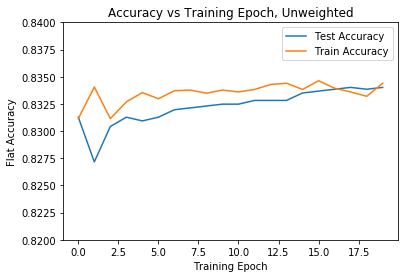

In [137]:
plot_accuracy(test_accuracy_tracker, train_accuracy_tracker, 0.82, 0.84)

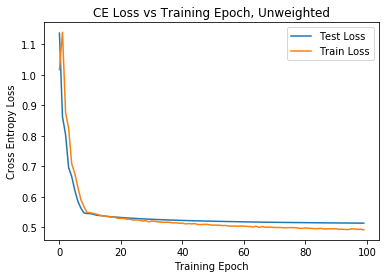

In [138]:
plot_loss(test_loss_tracker, train_loss_tracker)

Ok, this performance is a huge bummer, as adding weights just makes the network more stable, but doesn't actually change that it gets stuck at a certain level. This acutally makes me think that maybe the optimizer is the problem, and that maybe why we're having problems is that it gets stuck in a local minima, and can't get any better. 

Alternative problems could be either that the model isn't complex enough, that the data is too biased, or that I need to first run fine-tuning on the BERT encodings. 

To me, the BERT encodings seems the most likely to improve our overall performance. However, fine tuning the encodings will require some fun constructions. I think it makes more sense to try to bump up the model complexity first. I think this will then represent 4 distinct models for performance checking, if we do the fine-tuning work. Both with and without BERT embedding tunings and with a 1-layer and a 3-layer NN. 


****
## 3-layer NN Classifier Network

In [43]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [50]:
class Net_3_layer(nn.Module):
    def __init__(self, p = 0.1):
        super(Net_3_layer, self).__init__()
        self.classifier_dropout = nn.Dropout(p = p)
        self.classifier1 = nn.Linear(768, 3072)
        self.classifier2 = nn.Linear(3072, 3072)
        self.classifier3 = nn.Linear(3072 , 4)
        
    def forward(self, x):
        x = self.classifier_dropout(x)
        x = F.relu(self.classifier3(F.relu(self.classifier2(F.relu(self.classifier1(x))))))
        return x

### Opportunity for future improvement:
Use He initialization rather than Xavier for RELU usage, as it is shown to be better (?) 


nn.init.kaiming_normal_(w, mode='fan_out', nonlinearity='relu')

In [49]:
key_count_list = np.zeros(len(label_mapping.keys()))
for i in range(len(no_pad_labels)):
    key_count_list[no_pad_labels[i]] += 1
list_o_weights = (sum(key_count_list)/(len(label_mapping.keys())*key_count_list))
#calculate correct weight numbers for each value:
list_o_weights[0] = 0
list_o_weights = list_o_weights[:4]
#This above list of weights made it so we got no guesses for outside. Lets try to help balance it a bit. 
list_o_weights = list_o_weights/list_o_weights[3]

print(list_o_weights)

In [56]:
list_o_weights[1] = 4
list_o_weights[2] = 12
list_o_weights[3] = 1

In [57]:
#Set up a loss function instantiation, using cross-entropy loss:
weight_tensor = torch.tensor(list_o_weights, dtype = torch.float)
criterion = nn.CrossEntropyLoss(weight = weight_tensor)

In [48]:
def fractionated_accuracy(predictions, labels):
    """This function takes in logits and labels and determines accuracy for each label, and a total accuracy"""
    correct_count = [0,0,0,0]
    total_count = [0,0,0,0]
    max_preds = np.zeros(shape = len(labels))
    
    #Find actual function guesses, not just logits
    #NOTE: If the prediction gives identical values for two different labels (ie, both 1 and 2 are 0.5000)
    #this function just assigns it to be whichever came first in the array (ie, a 1). It shouldn't be THAT 
    #common across all of our samples to be a huge problem, but it's a bias worth noting. 
    for i in range(len(predictions)):
        max_preds[i] = np.where(predictions[i] == max(predictions[i]))[0][0]

    #Ok, the above finds the model's actual guess. Now we compare:
    for i in range(len(max_preds)):
        if max_preds[i] == labels[i]:
            correct_count[labels[i]] += 1
        total_count[labels[i]] += 1
            
    return correct_count[1]/total_count[1], correct_count[2]/total_count[2], correct_count[3]/total_count[3], sum(correct_count)/sum(total_count)


In [330]:
deep_net = Net_3_layer()

In [331]:
deep_net.float()

Net_3_layer(
  (classifier_dropout): Dropout(p=0.1, inplace=False)
  (classifier1): Linear(in_features=768, out_features=3072, bias=True)
  (classifier2): Linear(in_features=3072, out_features=3072, bias=True)
  (classifier3): Linear(in_features=3072, out_features=4, bias=True)
)

In [332]:
#Set up what we'll use as an optimizer, and call it optimizer
deep_optimizer = optim.SGD(deep_net.parameters(), lr = 0.1, momentum = 0.5)

In [60]:
#Now we need to make our training and testing tokens
train_NN_tokens, test_NN_tokens, train_NN_labels, test_NN_labels = train_test_split(no_pad_tokens, no_pad_labels)

In [61]:
#Ok, and then flip the training and testing tokens into a torch tensor.
torch_train_tokens = torch.tensor(train_NN_tokens, requires_grad = True)
torch_train_labels = torch.tensor(train_NN_labels)
torch_test_tokens = torch.tensor(test_NN_tokens, requires_grad = True)
torch_test_labels = torch.tensor(test_NN_labels)

In [335]:
deep_net.cpu()

Net_3_layer(
  (classifier_dropout): Dropout(p=0.1, inplace=False)
  (classifier1): Linear(in_features=768, out_features=3072, bias=True)
  (classifier2): Linear(in_features=3072, out_features=3072, bias=True)
  (classifier3): Linear(in_features=3072, out_features=4, bias=True)
)

In [336]:
train_loss_tracker = []
test_loss_tracker = []
test_predictions = []
total_test_accuracy = []
total_train_accuracy = []

#Set up something to track accuracy values for each label for each epoch
test_accuracy_tracker = [[]]
train_accuracy_tracker = [[]]
for i in range(len(set(test_NN_labels))):
    test_accuracy_tracker.append([])
    train_accuracy_tracker.append([])


#train for 100 epochs, cool. Lol it took like 30 seconds tops. 
for epoch in range(15):
    if epoch % 1 == 0:
        print("In epoch: ", epoch+1)
        flag = True
        
    else:
        flag = False
    
    deep_net.train()
    deep_optimizer.zero_grad()
    train_outputs = deep_net(torch_train_tokens)
    train_loss = criterion(train_outputs, torch_train_labels)
    train_loss.backward()
    deep_optimizer.step()
    #print(epoch)
    #Ok, we need some way to save the losses as we go. 
    train_loss_tracker.append(train_loss.item())
    #Really interesting to note that calc accuracy REALLY SLOWS THIS DOWN
    #Maybe sparsify accuracy to be ever 5 epochs?
    if flag:
        acc1, acc2, acc3, total_accuracy = fractionated_accuracy(train_outputs, torch_train_labels) 
        train_accuracy_tracker[0].append(0)
        train_accuracy_tracker[1].append(acc1)    
        train_accuracy_tracker[2].append(acc2)
        train_accuracy_tracker[3].append(acc3)
        total_train_accuracy.append(total_accuracy)
    
    #Once we've done a training step, then move to a testing step:
    deep_net.eval()
    #Make sure we don't have gradients going
    with torch.no_grad():
        test_outputs = deep_net(torch_test_tokens)
    
    #Ok, now calculate test_loss
    test_loss = criterion(test_outputs, torch_test_labels)
    test_loss_tracker.append(test_loss.item())
    
    
    numpy_test_outputs = test_outputs.detach().cpu().numpy()
    #Final step is to find some way to keep track of the model's predictions over time
    test_predictions.append(numpy_test_outputs)
    #Only calc testing acc every five as well
    if flag:
        acc1, acc2, acc3, total_accuracy = fractionated_accuracy(numpy_test_outputs, torch_test_labels) 
        test_accuracy_tracker[0].append(0)
        test_accuracy_tracker[1].append(acc1)    
        test_accuracy_tracker[2].append(acc2)
        test_accuracy_tracker[3].append(acc3)
        total_test_accuracy.append(total_accuracy)

In epoch:  1
In epoch:  2
In epoch:  3
In epoch:  4
In epoch:  5
In epoch:  6
In epoch:  7
In epoch:  8
In epoch:  9
In epoch:  10
In epoch:  11
In epoch:  12
In epoch:  13
In epoch:  14
In epoch:  15


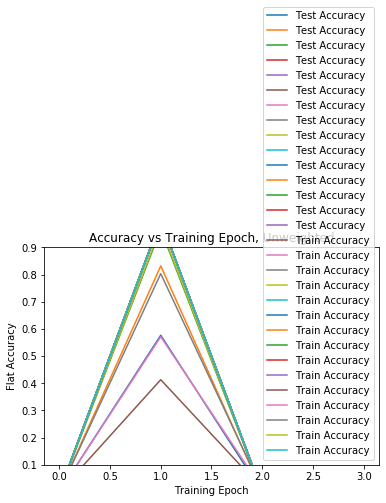

In [337]:
#Maybe build a bar graph version of conf. mat. that shows all guesses for things actually a 1, all for actually a 2, etc. 
#Might be more intuitive than the table we currently have
plot_accuracy(test_accuracy_tracker, train_accuracy_tracker, ylim_min = 0.1, ylim_max = 0.9)

In [338]:
make_confusion_matrix(test_predictions[-1], torch_test_labels.numpy(), prettify = True)

,Act_labels: 0,Act_labels: 1,Act_labels: 2,Act_labels: 3
Pred: 0,0.0,0.0,0.0,0.0
Pred: 1,0.0,725.0,239.0,4872.0
Pred: 2,0.0,0.0,0.0,2.0
Pred: 3,0.0,0.0,0.0,0.0


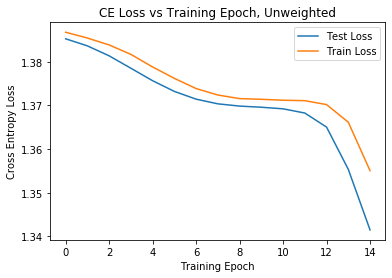

In [339]:
plot_loss(test_loss_tracker, train_loss_tracker)

Text(0.5, 0, 'Epochs/2')

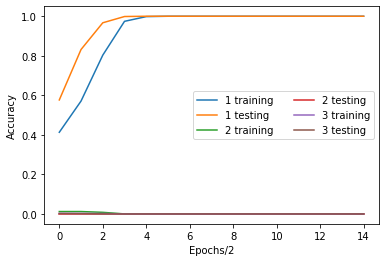

In [340]:
for i in range(len(train_accuracy_tracker)-1):
    plt.plot(train_accuracy_tracker[i+1], label = str(i+1) + str(" training"))
    plt.plot(test_accuracy_tracker[i+1], label = str(i+1) + str(" testing"))
plt.legend(ncol = 2)
plt.ylabel("Accuracy")
plt.xlabel("Epochs/2")

asdfsadf

In [90]:
fraction_accuracy = fractionated_accuracy(test_predictions[-1], torch_test_labels.numpy())

In [91]:
fraction_accuracy[1]

0.4658119658119658

In [92]:
fraction_accuracy[2]

0.6345759934453093

In [93]:
fraction_accuracy[3]

0.60517300445358

In [98]:
fake_list = [[],[],[],[]]
fake_list[1].append(fraction_accuracy[1])

In [100]:
fake_list[0]

[]

In [106]:
len(set(test_NN_labels))

3

In [110]:
fake_list2 = [[]]
for i in range(len(set(test_NN_labels))):
    print(i)
    fake_list2.append([])

0
1
2


In [111]:
fake_list2

[[], [], [], []]

# 5 Layer, lots of nodes, NN

Seems like our model isn't able to capture all the underlying complexity present, as evidenced by the fact that I can use weighting to get the model to learn more than one thing, but as it improves one thing, it loses performance on another label. So, we're going to expand our NN node counts, and see if we can't make the thing perform a bit better. We'll also step down more slowly to our 4 label classification, and see if that doesn't help. 

In [307]:
class Net_5_layer(nn.Module):
    def __init__(self, p = 0.02):
        super(Net_5_layer, self).__init__()
        #MIGHT NEED TO HAVE A DROPOUT LAYER BETWEEN EACH LINEAR LAYER?
        self.classifier_dropout = nn.Dropout(p = p)
        self.classifier1 = nn.Linear(768, 5000)
        self.classifier2 = nn.Linear(5000, 1000)
        self.classifier3 = nn.Linear(1000, 100)
        self.classifier4 = nn.Linear(100, 50)
        self.classifier5 = nn.Linear(50, 4)
        
    def forward(self, x):
        x = self.classifier_dropout(x)
        #MAYBE WE SHOULD REMOVE THE RELUs.
        #Seems quite likely, as I just had my model predict all 0. Thinking about it...
        #If all neurons are off, bc they were negative at one point, then all values for the final layer are 0
        #and so, we're seeing the function assume a guess of 0, since all values are 0 and it's trained to take
        #the first guess (ie, 0) as being the right one.
        x = self.classifier5(self.classifier4(self.classifier3(self.classifier2(self.classifier1(x)))))
        return x

In [308]:
key_count_list = np.zeros(len(label_mapping.keys()))
for i in range(len(no_pad_labels)):
    key_count_list[no_pad_labels[i]] += 1
list_o_weights = (sum(key_count_list)/(len(label_mapping.keys())*key_count_list))
#calculate correct weight numbers for each value:
list_o_weights[0] = 0
list_o_weights = list_o_weights[:4]
#This above list of weights made it so we got no guesses for outside. Lets try to help balance it a bit. 
list_o_weights = list_o_weights/list_o_weights[3]

print(list_o_weights)

C:\Users\Jonathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


[ 0.          6.70075758 19.71529889  1.        ]


In [309]:
list_o_weights[1] = 4.25
list_o_weights[2] = 13.8
list_o_weights[3] = 0.73

In [310]:
#Set up a loss function instantiation, using cross-entropy loss:
weight_tensor = torch.tensor(list_o_weights, dtype = torch.float)
criterion = nn.CrossEntropyLoss(weight = weight_tensor)

In [311]:
deepest_net = Net_5_layer()

In [312]:
#Set up what we'll use as an optimizer, and call it optimizer
deepest_optimizer = optim.SGD(deepest_net.parameters(), lr = 0.1, momentum = 0.5)

In [313]:
deepest_net.cpu()

Net_5_layer(
  (classifier_dropout): Dropout(p=0.02, inplace=False)
  (classifier1): Linear(in_features=768, out_features=5000, bias=True)
  (classifier2): Linear(in_features=5000, out_features=1000, bias=True)
  (classifier3): Linear(in_features=1000, out_features=100, bias=True)
  (classifier4): Linear(in_features=100, out_features=50, bias=True)
  (classifier5): Linear(in_features=50, out_features=4, bias=True)
)

In [314]:
train_loss_tracker = []
test_loss_tracker = []
test_predictions = []
total_test_accuracy = []
total_train_accuracy = []
train_predictions = []


#Set up something to track accuracy values for each label for each epoch
test_accuracy_tracker = [[]]
train_accuracy_tracker = [[]]
for i in range(len(set(test_NN_labels))):
    test_accuracy_tracker.append([])
    train_accuracy_tracker.append([])


#train for some number of epochs
for epoch in range(12):
    if epoch % 1 == 0:
        print("In epoch: ", epoch+1)
        flag = True
        
    else:
        flag = False
    
    deepest_net.train()
    deepest_optimizer.zero_grad()
    train_outputs = deepest_net(torch_train_tokens)
    train_loss = criterion(train_outputs, torch_train_labels)
    train_loss.backward()
    deepest_optimizer.step()

    #Ok, we need some way to save the losses as we go. 
    train_loss_tracker.append(train_loss.item())
    #Really interesting to note that calc accuracy REALLY SLOWS THIS DOWN
    #Maybe sparsify accuracy to be ever 5 epochs?
    if flag:
        acc1, acc2, acc3, total_accuracy = fractionated_accuracy(train_outputs, torch_train_labels) 
        train_accuracy_tracker[0].append(0)
        train_accuracy_tracker[1].append(acc1)    
        train_accuracy_tracker[2].append(acc2)
        train_accuracy_tracker[3].append(acc3)
        total_train_accuracy.append(total_accuracy)
    
    #Once we've done a training step, then move to a testing step:
    deepest_net.eval()
    #Make sure we don't have gradients going
    with torch.no_grad():
        test_outputs = deepest_net(torch_test_tokens)
    
    #Ok, now calculate test_loss
    test_loss = criterion(test_outputs, torch_test_labels)
    test_loss_tracker.append(test_loss.item())
    
    
    numpy_test_outputs = test_outputs.detach().cpu().numpy()
    numpy_train_outputs = train_outputs.detach().cpu().numpy()
    #Final step is to find some way to keep track of the model's predictions over time
    test_predictions.append(numpy_test_outputs)
    train_predictions.append(numpy_train_outputs)
    #Only calc testing acc every five as well
    if flag:
        acc1, acc2, acc3, total_accuracy = fractionated_accuracy(numpy_test_outputs, torch_test_labels) 
        test_accuracy_tracker[0].append(0)
        test_accuracy_tracker[1].append(acc1)    
        test_accuracy_tracker[2].append(acc2)
        test_accuracy_tracker[3].append(acc3)
        total_test_accuracy.append(total_accuracy)

In epoch:  1
In epoch:  2
In epoch:  3
In epoch:  4
In epoch:  5
In epoch:  6
In epoch:  7
In epoch:  8
In epoch:  9
In epoch:  10
In epoch:  11
In epoch:  12


Text(0.5, 0, 'Epochs')

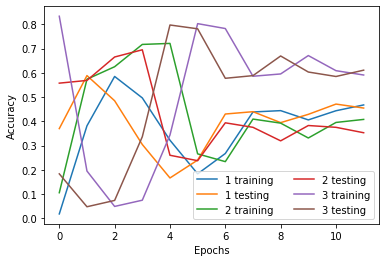

In [315]:
for i in range(len(train_accuracy_tracker)-1):
    plt.plot(train_accuracy_tracker[i+1], label = str(i+1) + str(" training"))
    plt.plot(test_accuracy_tracker[i+1], label = str(i+1) + str(" testing"))
plt.legend(ncol = 2)
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

In [323]:
train_accuracy_tracker[1][-1], train_accuracy_tracker[2][-1], train_accuracy_tracker[3][-1]

(0.4677716390423573, 0.40807799442896936, 0.5911639994528792)

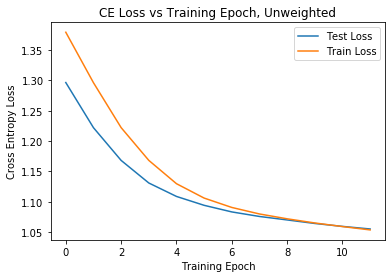

In [317]:
plot_loss(test_loss_tracker, train_loss_tracker)

In [318]:
test_pred_df = make_confusion_matrix(test_predictions[-1], torch_test_labels.numpy(), prettify = True)

In [319]:
test_pred_df

,Act_labels: 0,Act_labels: 1,Act_labels: 2,Act_labels: 3
Pred: 0,0.0,0.0,0.0,0.0
Pred: 1,0.0,333.0,65.0,1078.0
Pred: 2,0.0,109.0,95.0,803.0
Pred: 3,0.0,290.0,109.0,2956.0


In [320]:
train_pred_df = make_confusion_matrix(train_predictions[-2], torch_train_labels.numpy(), prettify = True)

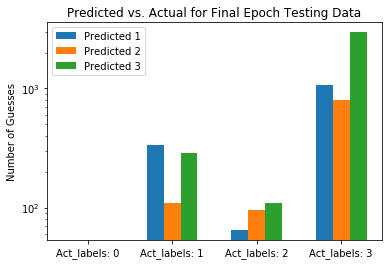

In [321]:
#Need a function that makes a bar plot of this. 
x = np.arange(len(test_pred_df.columns))
width = 0.2

fig, ax = plt.subplots()
pred1 = ax.bar(x-width, test_pred_df.iloc[1], width, label = "Predicted 1")
pred2 = ax.bar(x, test_pred_df.iloc[2], width, label = "Predicted 2")
pred3 = ax.bar(x+width, test_pred_df.iloc[3], width, label = "Predicted 3")

ax.set_title("Predicted vs. Actual for Final Epoch Testing Data")
ax.set_yscale('log')
ax.set_ylabel("Number of Guesses")
ax.set_xticks(x)
ax.set_xticklabels(test_pred_df.columns)
ax.legend()

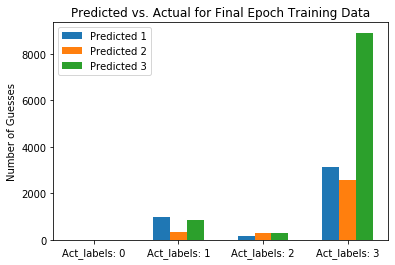

In [322]:
#Need a function that makes a bar plot of this. 
x = np.arange(len(train_pred_df.columns))
width = 0.2

fig, ax = plt.subplots()
pred1 = ax.bar(x-width, train_pred_df.iloc[1], width, label = "Predicted 1")
pred2 = ax.bar(x, train_pred_df.iloc[2], width, label = "Predicted 2")
pred3 = ax.bar(x+width, train_pred_df.iloc[3], width, label = "Predicted 3")

ax.set_title("Predicted vs. Actual for Final Epoch Training Data")
ax.set_ylabel("Number of Guesses")
ax.set_xticks(x)
ax.set_xticklabels(train_pred_df.columns)
ax.legend()

Ok, so it seems like we're getting places with messing with the classifier weights. Let's do something a bit more robust, and search the space a bit more thoroughly.

Right now, we've gotten good-ish results with weights of 0, 6, 14, and 2. We had ok results with outside tokens being weighted at 1, but this seems better. Let's explore this space. 

In [249]:
weight_set_1 = np.linspace(4, 14, num = 5)
weight_set_2 = np.linspace(8, 28, num = 5)
weight_set_3 = np.linspace(1, 4, num = 2)

In [250]:
print(weight_set_1)
print(weight_set_2)
print(weight_set_3)

[ 4.   6.5  9.  11.5 14. ]
[ 8. 13. 18. 23. 28.]
[1. 4.]


In [262]:
weight_search_dict = []
for i in weight_set_1:
    for j in weight_set_2:
        for k in weight_set_3:
            train_loss_tracker = []
            test_loss_tracker = []
            test_predictions = []
            test_accuracy_tracker = []
            train_accuracy_tracker = []
            
            print("Training for weight combination: " + str(i) + ', ' + str(j) + ', ' + str(k))
                        
            #Between each weight set, we need to reset our model:
            weight_search_tensor = torch.tensor([0, i, j, k], dtype = torch.float)
            criterion = nn.CrossEntropyLoss(weight = weight_search_tensor)
            deep_net = Net_3_layer()
            deep_net.float()
            deep_optimizer = optim.SGD(deep_net.parameters(), lr = 0.1, momentum = 0.5)
            
            for epoch in range(25):
                if epoch % 5 == 0:
                    print("In epoch: ", epoch)
                    flag = True
                else:
                    flag = False

                deep_net.train()
                deep_optimizer.zero_grad()
                train_outputs = deep_net(torch_train_tokens)
                train_loss = criterion(train_outputs, torch_train_labels)
                train_loss.backward()
                deep_optimizer.step()
                #print(epoch)
                #Ok, we need some way to save the losses as we go. 
                train_loss_tracker.append(train_loss.item())
                #Really interesting to note that calc accuracy REALLY SLOWS THIS DOWN
                #Maybe sparsify accuracy to be ever 5 epochs?
                if flag:
                    train_accuracy_tracker.append(flat_accuracy(train_outputs, torch_train_labels))

                #Once we've done a training step, then move to a testing step:
                deep_net.eval()
                #Make sure we don't have gradients going
                with torch.no_grad():
                    test_outputs = deep_net(torch_test_tokens)

                #Ok, now calculate test_loss
                test_loss = criterion(test_outputs, torch_test_labels)
                test_loss_tracker.append(test_loss.item())


                numpy_test_outputs = test_outputs.detach().cpu().numpy()
                #Final step is to find some way to keep track of the model's predictions over time
                test_predictions.append(numpy_test_outputs)
                #Only calc testing acc every five as well
                if flag:
                    test_accuracy_tracker.append(flat_accuracy(numpy_test_outputs, torch_test_labels))
                       
            
            weight_search_dict.append(
            {
                'Weight Set': str(i) + ', ' + str(j) + ', ' + str(k),
                'Training Loss': train_loss_tracker,
                "Test Loss": test_loss_tracker,
                'Test Predictions': test_predictions,
                'Test Accuracy': test_accuracy_tracker,
                'Train Accuracy': train_accuracy_tracker           
            }
            )

Training for weight combination: 4.0, 8.0, 1.0
In epoch:  0
In epoch:  5
In epoch:  10
In epoch:  15
In epoch:  20
Training for weight combination: 4.0, 8.0, 4.0
In epoch:  0
In epoch:  5
In epoch:  10
In epoch:  15
In epoch:  20
Training for weight combination: 4.0, 13.0, 1.0
In epoch:  0
In epoch:  5
In epoch:  10
In epoch:  15
In epoch:  20
Training for weight combination: 4.0, 13.0, 4.0
In epoch:  0
In epoch:  5
In epoch:  10
In epoch:  15
In epoch:  20
Training for weight combination: 4.0, 18.0, 1.0
In epoch:  0
In epoch:  5
In epoch:  10
In epoch:  15
In epoch:  20
Training for weight combination: 4.0, 18.0, 4.0
In epoch:  0
In epoch:  5
In epoch:  10
In epoch:  15
In epoch:  20
Training for weight combination: 4.0, 23.0, 1.0
In epoch:  0
In epoch:  5
In epoch:  10
In epoch:  15
In epoch:  20
Training for weight combination: 4.0, 23.0, 4.0
In epoch:  0
In epoch:  5
In epoch:  10
In epoch:  15
In epoch:  20
Training for weight combination: 4.0, 28.0, 1.0
In epoch:  0
In epoch:  5


In [242]:
weight_search_dict

[{'Weight Set': '13.0',
  'Training Loss': [1.3831934928894043,
   1.2795281410217285,
   1.1958547830581665,
   1.1720670461654663,
   1.158272385597229,
   1.1581376791000366],
  'Test Loss': [1.2828214168548584,
   1.1961265802383423,
   1.1739214658737183,
   1.168946385383606,
   1.171460747718811,
   1.1613235473632812],
  'Test Predictions': [array([[0.        , 0.20708519, 0.        , 0.45446303],
          [0.        , 0.11050657, 0.        , 0.4086007 ],
          [0.        , 0.2606971 , 0.        , 0.5298337 ],
          ...,
          [0.        , 0.16242228, 0.        , 0.43669656],
          [0.        , 0.2877741 , 0.        , 0.51892114],
          [0.        , 0.25631315, 0.        , 0.4830596 ]], dtype=float32),
   array([[0.        , 0.448964  , 0.        , 1.13665   ],
          [0.        , 0.29050428, 0.        , 1.0432982 ],
          [0.        , 0.546753  , 0.        , 1.3119035 ],
          ...,
          [0.        , 0.35706168, 0.        , 1.123463  ],
    

Text(0.5, 0, 'Epoch')

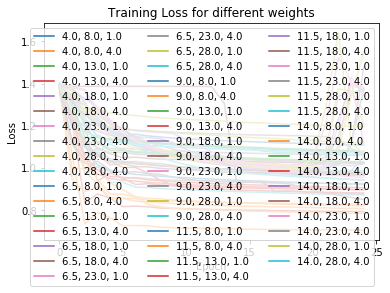

In [284]:
for i in range(len(weight_search_dict)):
    plt.plot(weight_search_dict[i]['Training Loss'], label = weight_search_dict[i]['Weight Set'])
plt.legend(ncol = 3)
plt.title("Training Loss for different weights")
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.savefig("Crappy loss with various weights 3 layer nn.tif")

In [ ]:
for i in range(len(weight_search_dict)):
    plt.plot(weight_search_dict[i]['Training Loss'], label = weight_search_dict[i]['Weight Set'])
plt.legend()
plt.title("Training Loss for different weights")
plt.ylabel("Loss")
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

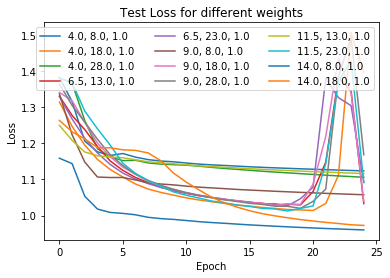

In [273]:
for i in range(int(len(weight_search_dict)/4)):
    plt.plot(weight_search_dict[i*4]['Test Loss'], label = weight_search_dict[i*4]['Weight Set'])
plt.legend(ncol = 3)
plt.title("Test Loss for different weights")
plt.ylabel("Loss")
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

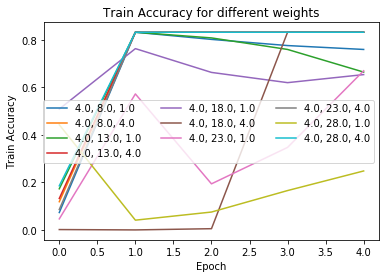

In [274]:
for i in range(10):
    plt.plot(weight_search_dict[i]['Train Accuracy'], label = weight_search_dict[i]['Weight Set'])
plt.legend(ncol = 3)
plt.title("Train Accuracy for different weights")
plt.ylabel("Train Accuracy")
plt.xlabel("Epoch")

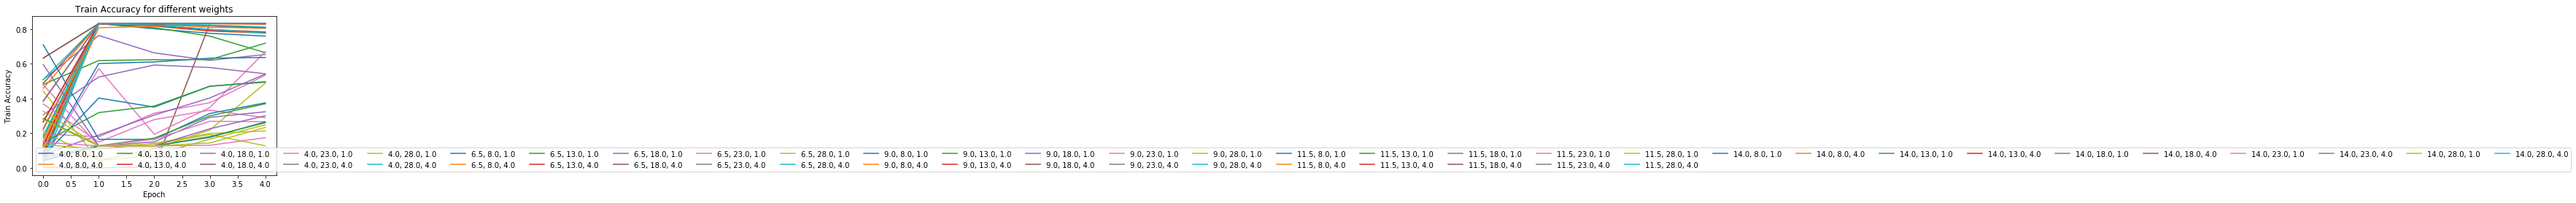

In [283]:
for i in range(len(weight_search_dict)):
    plt.plot(weight_search_dict[i]['Train Accuracy'], label = weight_search_dict[i]['Weight Set'])
plt.legend(ncol = 30)
plt.title("Train Accuracy for different weights")
plt.ylabel("Train Accuracy")
plt.xlabel("Epoch")
#plt.savefig("Train accuracy for a bunch of weights 3 layer nn.tif")

Text(0.5, 0, 'Train Accuracy')

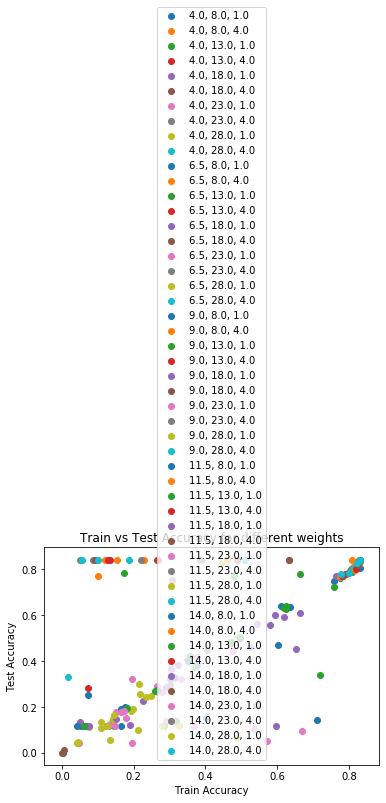

In [264]:
for i in range(len(weight_search_dict)):
    plt.scatter(weight_search_dict[i]['Train Accuracy'], weight_search_dict[i]['Test Accuracy'], label = weight_search_dict[i]['Weight Set'])
plt.legend()
plt.title("Train vs Test Accuracy for different weights")
plt.ylabel("Test Accuracy")
plt.xlabel("Train Accuracy")

## Next step: Implement own custom loss function. 
It's clear that part of the problem is the model just gets satisfied with making correct outside guesses, and stops learning. We need to punish it for not getting the non-outside tokens more aggressively, and have a lower reward for getting the outside tokens correct. 

--Ripped straight from internet. Gives template for how to engineer loss function correctly.

def my_loss(output, target):
    loss = torch.mean((output - target)**2)
    return loss

model = nn.Linear(2, 2)
x = torch.randn(1, 2)
target = torch.randn(1, 2)
output = model(x)
loss = my_loss(output, target)
loss.backward()
print(model.weight.grad)

In [98]:
train_outputs.shape

torch.Size([17512, 4])

In [99]:
torch_train_labels.shape

torch.Size([17512])

In [100]:
torch_train_labels[4]

tensor(3)

In [ ]:
def my_loss(output, target):
    #Need to handle this where getting the outside wrong adds to error by not even the squared difference, just the absolute value
    #But getting the properties or the molecules wrong goes by like the fourth power or something. 
    #This is a two part problem
    #We need to first select the max from the list of outputs, as outputs is a shape 17512,4. 
    #Remember that 3 is the label value for an outside token
    
    for i in range(len(target)):
        if target[i] == 0:
            #This is the case of padding: Shouldn't add to our loss
            pass
        #If it is mapping a molecule
        if target[i] == 1:
            asdfasd
        #If it is mapping a property
        if target[i] == 2:
            asdfadsf
        #If it is mapping a property
        if target[i] == 3:
            #loss += torch.abs(torch.add(1, -output[i]))
            
    

In [101]:
if torch_train_labels[4] == 3:
    print("Yeah")

Yeah


****

# Fine-tuning BERT Encodings

--Ok, so my brilliant self thought this was a good idea --- However, in order to do this, you have to actually use a full BERT model with a full classification layer built on top, otherwise it has no way to computer loss and update weights. IDK. I guess within an outer BERT train epoch, take the outputs of the BERT model, then use those outputs to go through a full round of training on the classifier NN, then use the loss from the final training round there to update the BERT model encodings? This seems insane. But maybe worth mentioning it to DB or JP? 


---That above is actually not entirely true. You could instead build a fine-tuning corpus that teaches the BERT embeddings based on your own custom corpus. But you would have to run a different model of classification. See: https://github.com/google-research/bert section: "Pre-training with BERT". All that being said, I'm not sure I could do a better job than the base embeddings without a massive cloud TPU. 

----A final potential solution here is that I could try to use the BERT-Large model. It's bigger, so that's something.

In [141]:
from transformers import get_linear_schedule_with_warmup
from transformers import BertForTokenClassification, AdamW, BertConfig
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, random_split

In [142]:
FT_model = BertModel.from_pretrained(
        "bert-base-uncased",
        output_attentions = False, #Whether model returns attention weights
        output_hidden_states = False, #Whether model outputs all hidden states
)    

In [148]:
tensor_dataset = TensorDataset(input_tokens, attention_mask)

In [149]:
#Set a dataloader batch size. Paper says do 16 or 32, but do bigger if comp can
batch_size = 32

#Create training dataloaders using a random sequence pull
train_dataloader = DataLoader(tensor_dataset,
                             sampler = RandomSampler(tensor_dataset),
                             batch_size = batch_size
                             )

In [143]:
FT_model.cpu()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [152]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(FT_model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [153]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 1. Largely cause I'm not sure my computer will survive
#This could also be a major source of error. I'm thinking I'll try 2 next and pray.
#When I ran for 20 epochs, the model saturated around 5 epochs with 2e-5 lr though.
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [154]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []
#Gotta get these to build a confusion matrix.
predictions, true_labels = [], []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    #Reset the confusion matrix for this epoch
    #Note that conf mat shape has axis 0 being actual label, axis 1 being guessed label
    conf_mat = np.zeros(shape = (4,4))

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    FT_model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 3 batches.
        if step % 3 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        FT_model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        logits = FT_model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))



